In [2]:
import plotly.offline as py
import plotly.graph_objs as go
import pandas as pd
import numpy as np
from datetime import datetime
from plotly.figure_factory import create_candlestick
import time
import matplotlib.pyplot as plt
import seaborn as sns
from calculator.talibWrapper import calculateTalib, talibFunctionInfo
%matplotlib inline
py.init_notebook_mode()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# Properties

In [3]:
dataRoot = 'D:\\Dropbox\\My work\\krypl-project\\dataLabeled\\poloniex\\5min'
featuresRoot = 'D:\\Dropbox\\My work\\krypl-project\\dataFeatures\\poloniex\\5min'

In [4]:
fileName = 'USDT_BTC_5min_2016-01-01_2017-12-31.tsv'
file = '{dataRoot}\\{fileName}'.format(dataRoot=dataRoot, fileName=fileName)
data = pd.read_csv(file, sep='\t')

In [5]:
outputFile = '{featuresRoot}\\{fileName}'.format(featuresRoot=featuresRoot, fileName=fileName)

# Sliding Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression

def getSlope(x):
#     x = data[['close']].iloc[1000:1012, :]
    y = np.array(list(range(x.shape[0])))
    regr = LinearRegression().fit(x, y)
    slope = regr.coef_[0]
    return slope


def slopeLabelIteration(dfCol, i, numOfPoints):
    if i % 100000 == 0:
        print(i)
    toI = i + numOfPoints if i + numOfPoints < dfCol.shape[0] else dfCol.shape[0]
    x = dfCol.iloc[i:toI]
    return getSlope(x)


def labelWithSlope(data, numOfPoints, col):
    dfCol = data[[col]]
    slope = dfCol.apply(lambda x: slopeLabelIteration(dfCol, x.name,numOfPoints), axis=1)
    data['labelSlope_%s_%d' % (col, numOfPoints)] = slope
    return data

In [6]:
labeledData = labelWithSlope(data, 12, 'close')

0
100000
200000


In [8]:
labeledData.to_csv(file, index=False, sep='\t')

## Regression Features

In [7]:
def slopeFeatureIteration(dfCol, i, numOfPoints):
    st = i - numOfPoints + 1
    fromI = st if st >= 0 else 0
    x = dfCol.iloc[fromI:i+1]
    return getSlope(x)


def featureSlope(data, numOfPoints, col):
    dataCp = data.copy()
    dfCol = dataCp[[col]]
    slope = dfCol.apply(lambda x: slopeFeatureIteration(dfCol, x.name,numOfPoints), axis=1)
    dataCp['slope_%s_%d' % (col, numOfPoints)] = slope
    return dataCp

In [31]:
featured = data
for col in ['close', 'open', 'high', 'low', 'volume']:
    for numOfPoints in [6, 12, 18, 24]:
        print(col, numOfPoints, end='')
        featured = featureSlope(featured, numOfPoints, col)
        print('\t done')

close 6	 done
close 12	 done
close 18	 done
close 24	 done
open 6	 done
open 12	 done
open 18	 done
open 24	 done
high 6	 done
high 12	 done
high 18	 done
high 24	 done
low 6	 done
low 12	 done
low 18	 done
low 24	 done
volume 6	 done
volume 12	 done
volume 18	 done
volume 24	 done


In [56]:
featured.sort_values('timestamp').to_csv(outputFile, index=False, sep='\t')

# Explore Labels

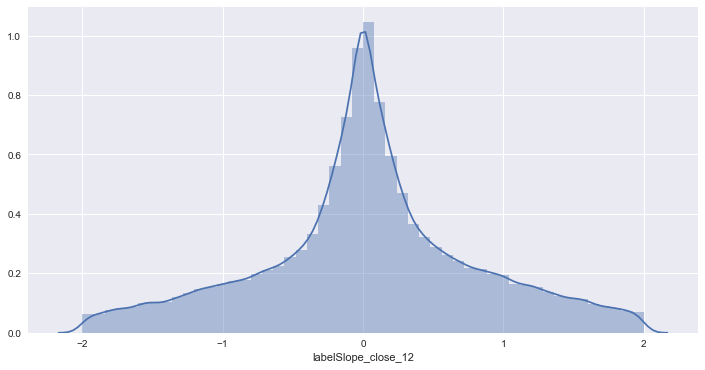

In [14]:
selected = labeledData.query('labelSlope_close_12 >= -2').query('labelSlope_close_12 <= 2')

plt.figure(figsize=[12, 6])
label = selected['labelSlope_close_12']
sns.distplot(label)

# Explore Features

In [35]:
featured.columns

Index(['close', 'timestamp', 'high', 'low', 'open', 'quoteVolume', 'volume',
       'weightedAverage', 'date', 'entryReturn_001', 'entryReturn_003',
       'entryReturn_006', 'entryReturn_01', 'entryReturn_03', 'entryReturn_05',
       'entryReturn_07', 'entryReturn_1', 'entryReturn_12', 'entryReturn_15',
       'entryReturn_18', 'entryReturn_2', 'entryReturn_22', 'entryReturn_25',
       'entryReturn_28', 'entryReturn_3', 'labelSlope_close_12',
       'slope_close_6', 'slope_close_12', 'slope_close_18', 'slope_close_24',
       'slope_open_6', 'slope_open_12', 'slope_open_18', 'slope_open_24',
       'slope_high_6', 'slope_high_12', 'slope_high_18', 'slope_high_24',
       'slope_low_6', 'slope_low_12', 'slope_low_18', 'slope_low_24',
       'slope_volume_6', 'slope_volume_12', 'slope_volume_18',
       'slope_volume_24'],
      dtype='object')

In [54]:
def plotDistb(data, label, feature):
    selected = data.query('{label} <= -0.5 or {label} >= 0.5'.format(label=label))
    data0 = selected[selected[label] > 0]
    data1 = selected[selected[label] < 0]
    f, axarr = plt.subplots(1, 2, figsize=[15, 5])
    plt.suptitle('Label = %s Feature = %s' % (label, feature))
    sns.distplot(data0[feature], ax=axarr[0], kde=True)
    sns.distplot(data1[feature], ax=axarr[1], kde=True)

In [53]:
featured.query('{label} <= -0.5 or {label} >= 0.5'.format(label=label)).shape

(108673, 46)

In [9]:
label = 'labelSlope_close_12'
features = ['slope_close_6', 'slope_close_12', 'slope_close_18', 'slope_close_24',
       'slope_open_6', 'slope_open_12', 'slope_open_18', 'slope_open_24',
       'slope_high_6', 'slope_high_12', 'slope_high_18', 'slope_high_24',
       'slope_low_6', 'slope_low_12', 'slope_low_18', 'slope_low_24',
       'slope_volume_6', 'slope_volume_12', 'slope_volume_18',
       'slope_volume_24']

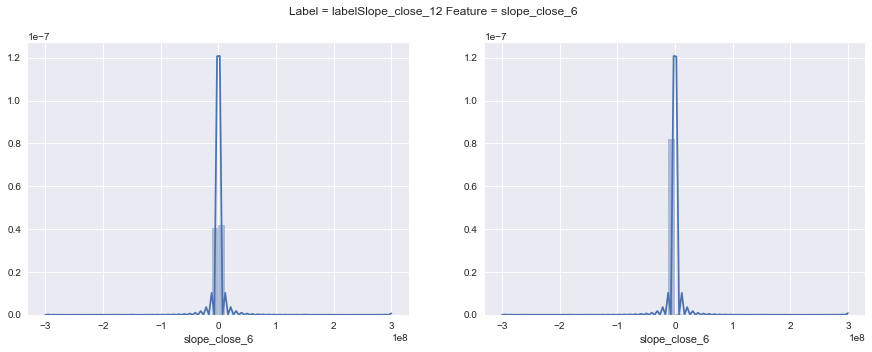

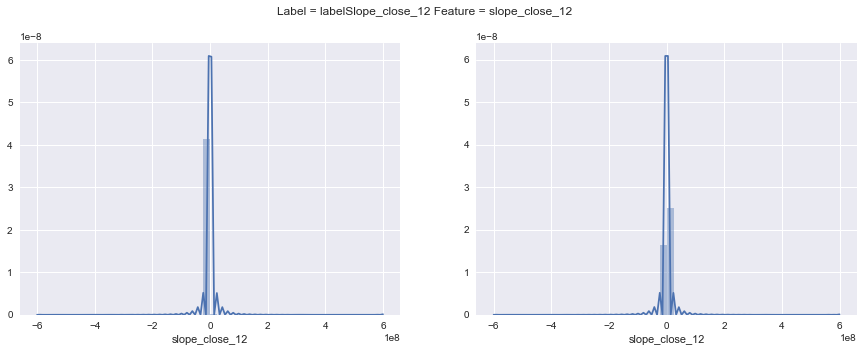

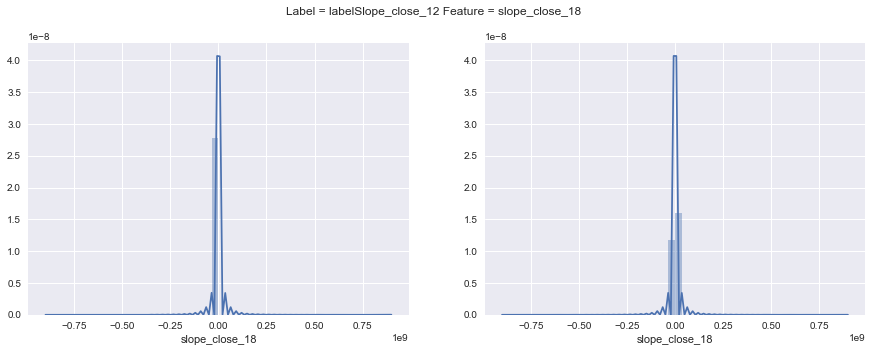

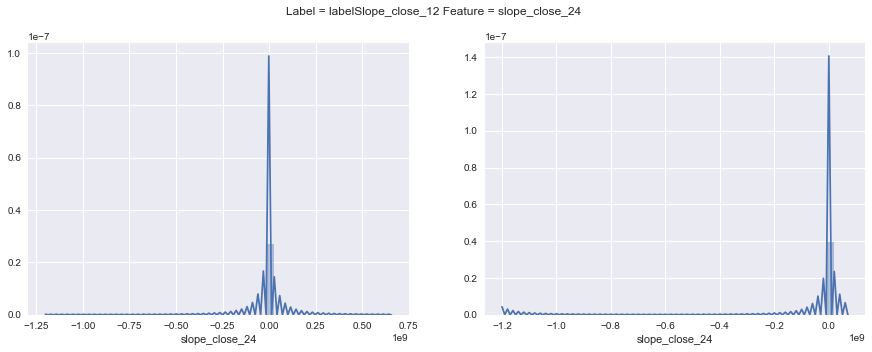

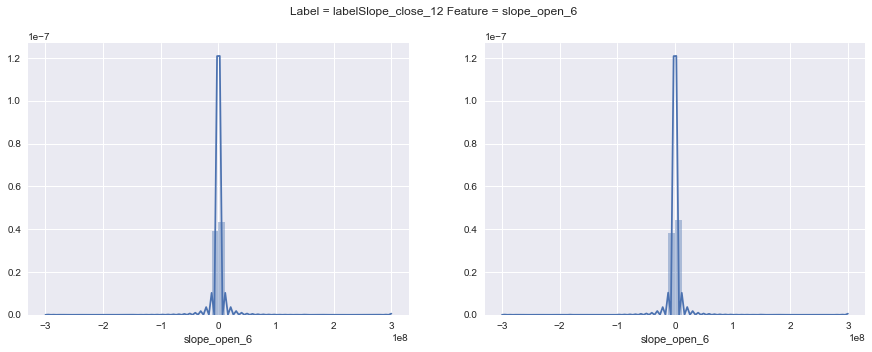

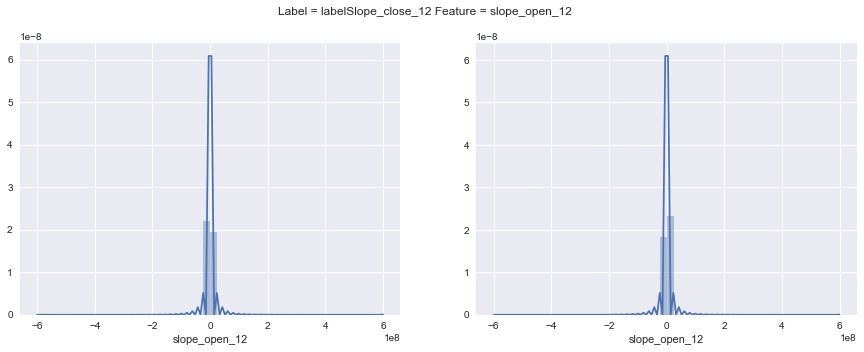

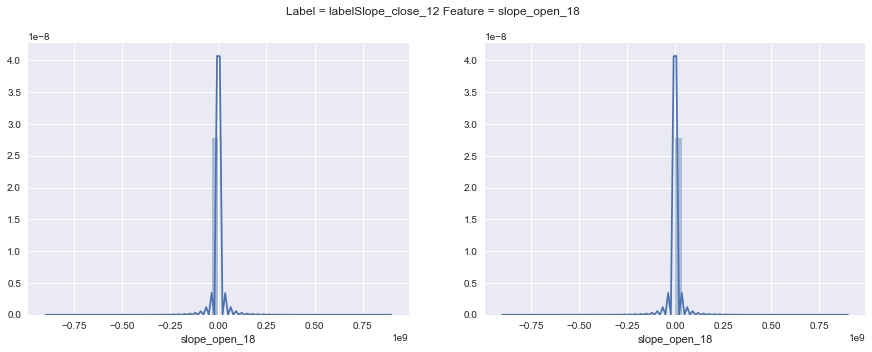

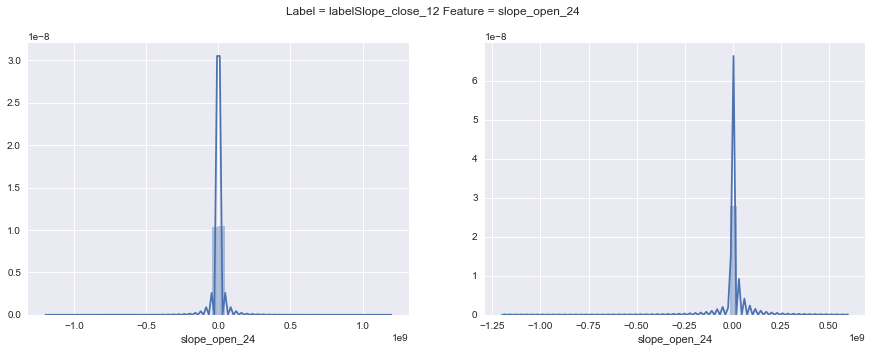

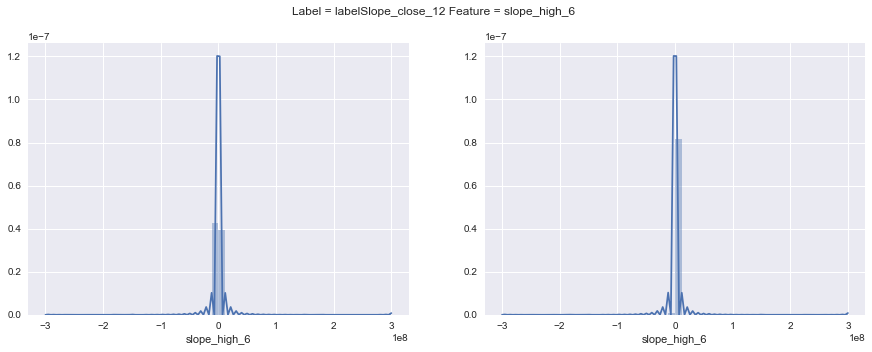

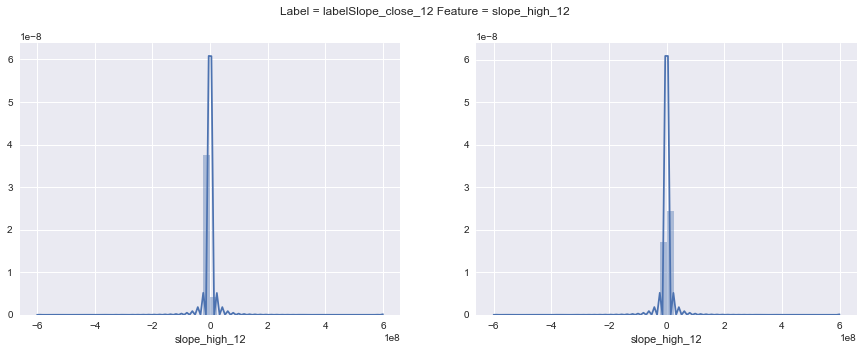

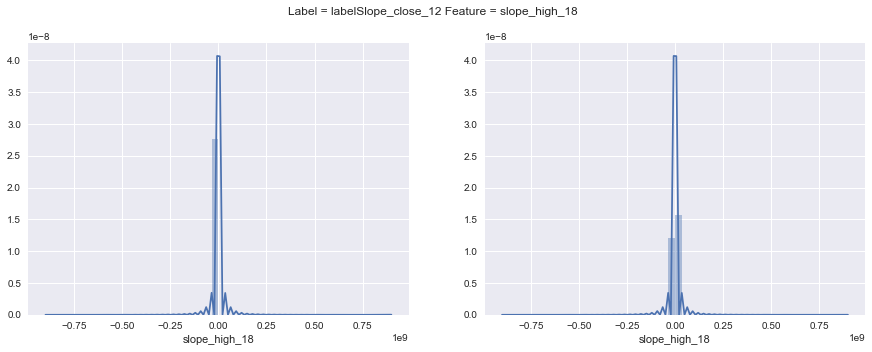

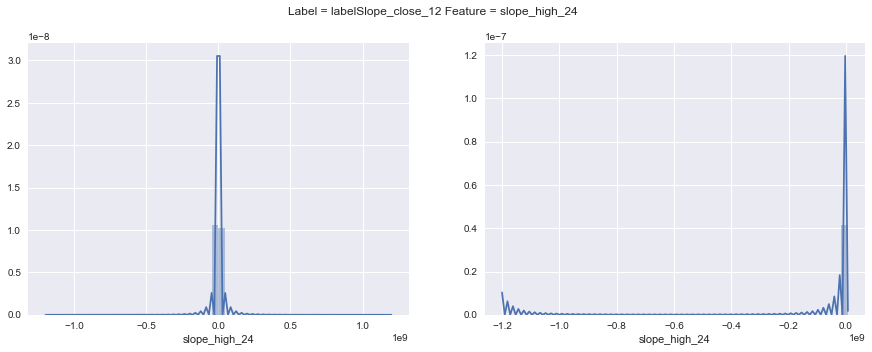

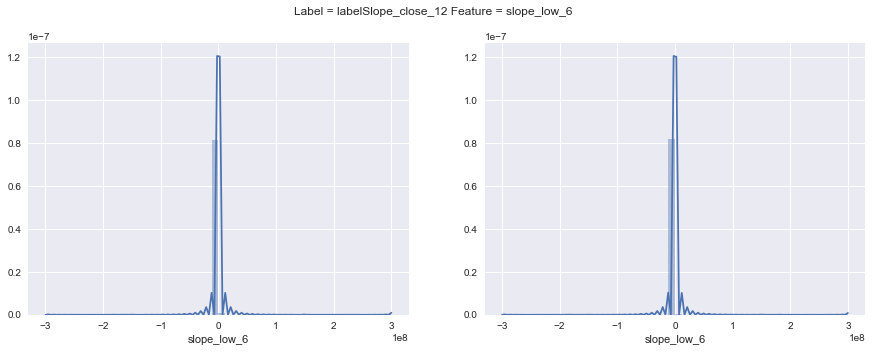

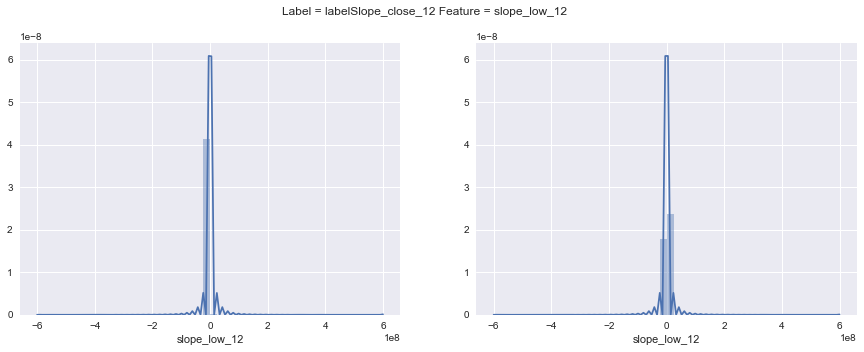

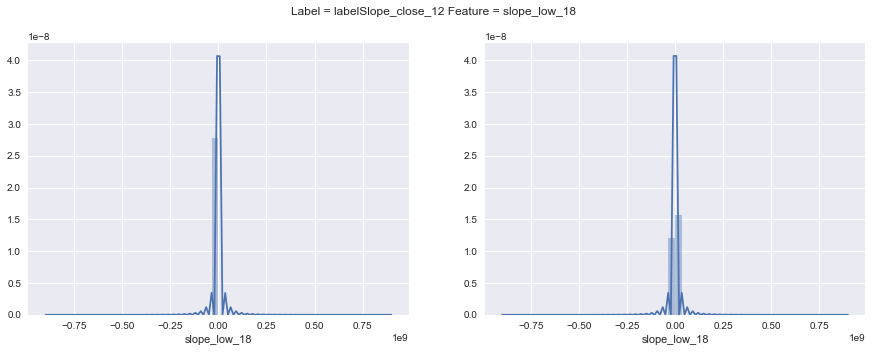

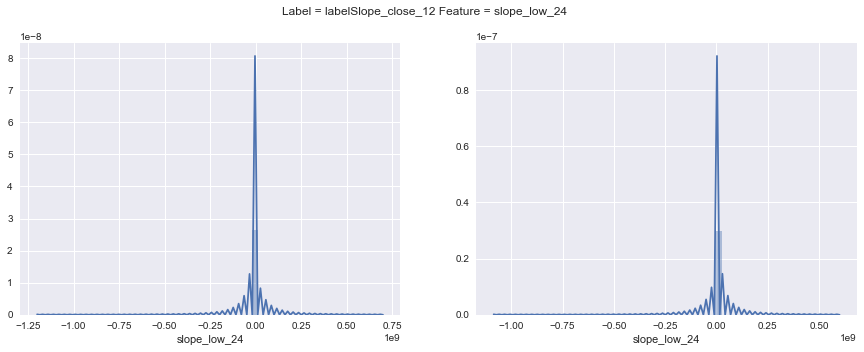

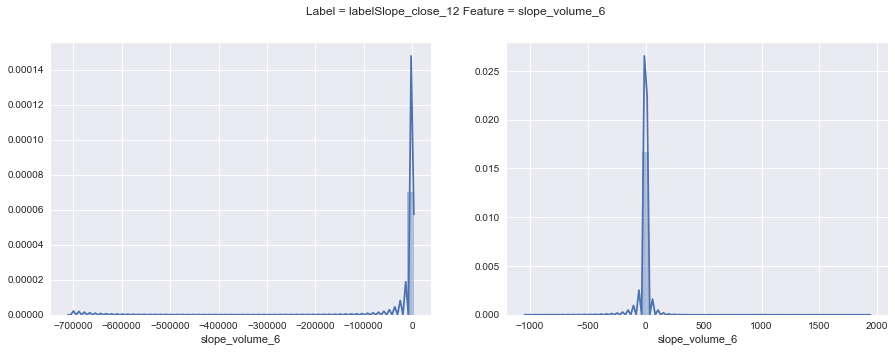

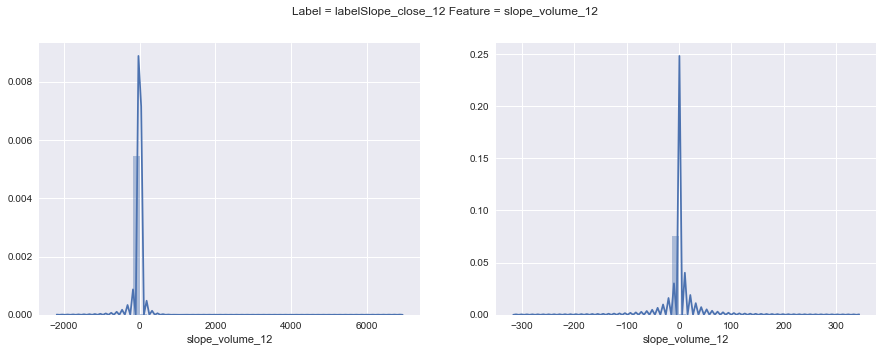

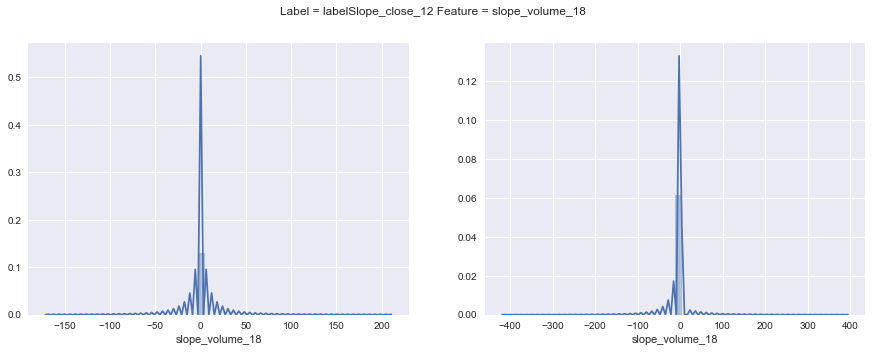

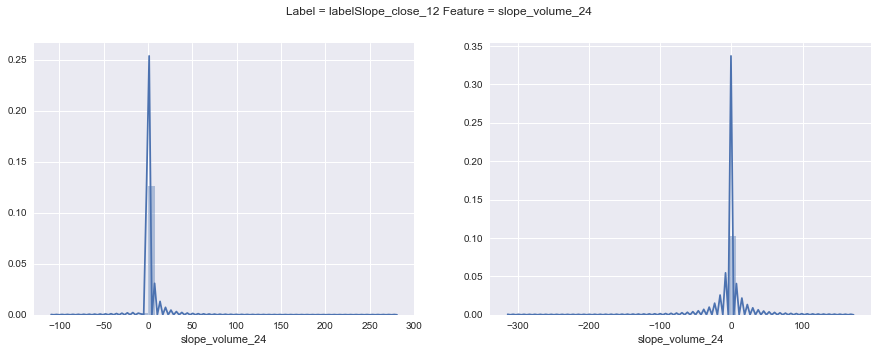

In [55]:
for f in features:
    plotDistb(featured, label, f)

# Simple Regression

In [8]:
featured = pd.read_csv(outputFile, sep='\t')

In [11]:
from sklearn.tree import DecisionTreeRegressor
sortedF = featured.sort_values('timestamp')
X = sortedF[features]
y = sortedF[label]

trainRatio = 0.7
trainSize = int(X.shape[0] * trainRatio)
X_train, y_train = X.iloc[:trainSize, :], y.iloc[:trainSize]
X_test, y_test = X.iloc[trainSize:, :], y.iloc[trainSize:]

# Fit regression model
regr = DecisionTreeRegressor()
regr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [13]:
# Predict
y_pred = regr.predict(X_test)

In [15]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

16489639818370.627